In [86]:
import pandas as pd
import numpy as np 

output_dir = "./outputs/"

## Initial Data
Data collected on 04/16

In [87]:
dart_user = pd.read_csv("./data/First/dart_user.csv", header=0)  
token_usage = pd.read_csv("./data/First/token_usage_log.csv")
gpu_power_usage = pd.read_csv("./data/First/GPU Power Usage-data-as-joinbyfield-2025-04-16 11_34_47.csv", header = 1)


# merged 
df = pd.merge(token_usage, dart_user, how='left', left_on='user_id', right_on='user_id')



In [88]:
df['total_tokens'] = df['prompt_tokens'] + df['response_tokens']  

# bucket times into 1 hours intervals
df['time_bucket'] = pd.to_datetime(df['log_date'], format = 'mixed').dt.floor('h')
# group by user_id and time_bucket, then sum the total_tokens
df['day'] = df['time_bucket'].dt.date
# group by day and sum the total_tokens
df['hour'] = df['time_bucket'].dt.hour
# plot token usage by the day 

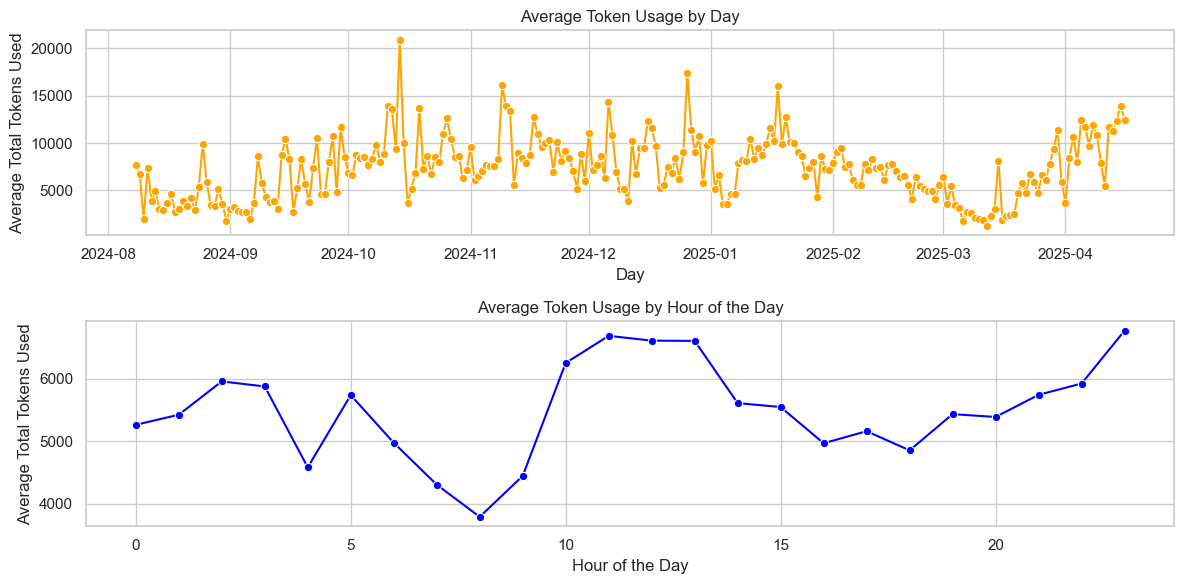

<Figure size 640x480 with 0 Axes>

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by hour and day to calculate mean total tokens
token_usage_hour = df.groupby(['hour']).agg({'total_tokens': 'mean'}).reset_index()
token_usage_day = df.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()



# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot average token usage by day
plt.subplot(2, 1, 1)
sns.lineplot(data=token_usage_day, x='day', y='total_tokens', marker='o', color='orange')
plt.xlabel('Day')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Day')

# Plot average token usage by hour
plt.subplot(2, 1, 2)
sns.lineplot(data=token_usage_hour, x='hour', y='total_tokens', marker='o', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Hour of the Day')

# Show the plots
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_by_day_and_hour.png")

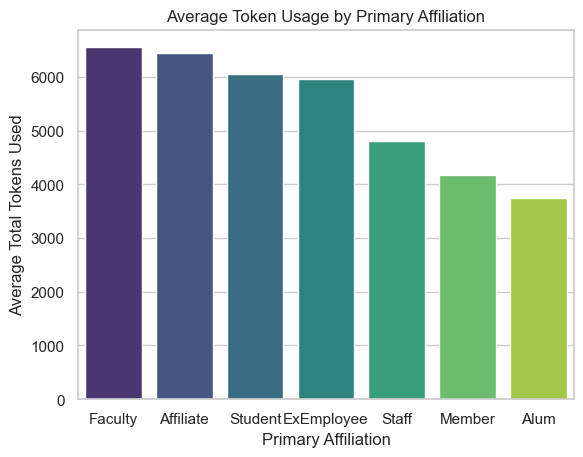

In [90]:
df_affiliation = df.groupby(['primary_affiliation']).agg({'total_tokens': 'mean'}).reset_index()
df_department = df.groupby(['department']).agg({'total_tokens': 'mean'}).reset_index()

df_affiliation = df_affiliation.sort_values(by='total_tokens', ascending=False)
# plot
# Plot average token usage by primary affiliation
sns.barplot(data=df_affiliation, x='primary_affiliation', y='total_tokens', hue = 'primary_affiliation', palette='viridis')
plt.xlabel('Primary Affiliation')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Primary Affiliation')
plt.savefig(f"{output_dir}/token_usage_by_affiliation.png")
pass
# sort



C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\3923602625.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


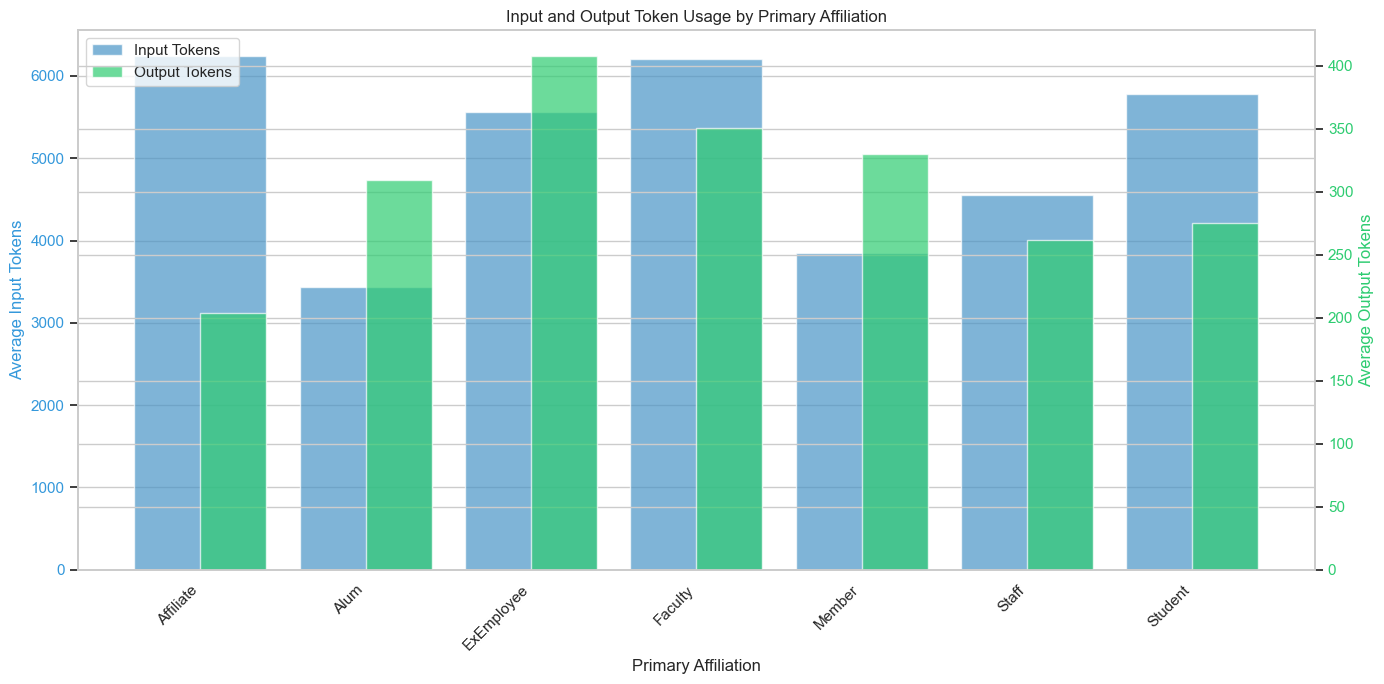

<Figure size 640x480 with 0 Axes>

In [91]:
# First, modify the aggregation to get both input and output tokens
df_affiliation = df.groupby(['primary_affiliation']).agg({
    'prompt_tokens': 'mean',
    'response_tokens': 'mean'
}).reset_index()

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot input tokens on primary axis (left)
color1 = '#3498db'  # Blue
sns.barplot(
    data=df_affiliation,
    x='primary_affiliation',
    y='prompt_tokens',
    color=color1,
    alpha=0.7,
    ax=ax1,
    label='Input Tokens'
)
ax1.set_xlabel('Primary Affiliation')
ax1.set_ylabel('Average Input Tokens', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = '#2ecc71'  # Green
bar_positions = np.arange(len(df_affiliation))
bar_width = 0.4
ax2.bar(
    bar_positions + bar_width/2,  # Offset bars slightly
    df_affiliation['response_tokens'],
    width=bar_width,
    color=color2,
    alpha=0.7,
    label='Output Tokens'
)
ax2.set_ylabel('Average Output Tokens', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title
plt.title('Input and Output Token Usage by Primary Affiliation')

# Add legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Show plot with adjusted layout
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_by_affiliation_input_output.png")

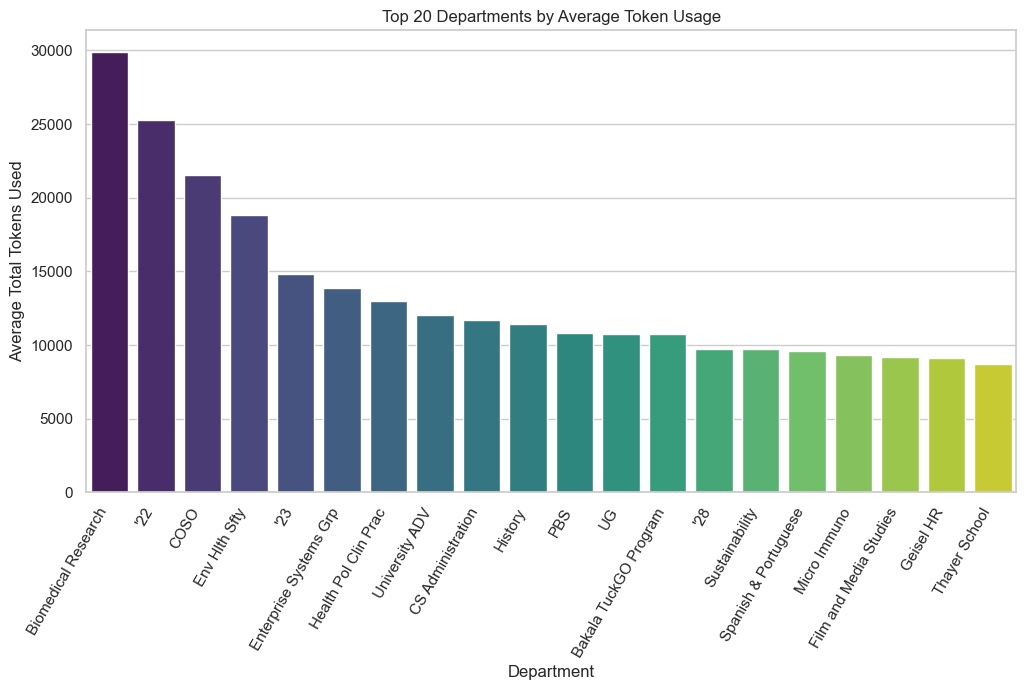

In [92]:
df_department.sort_values(by='total_tokens', ascending=False, inplace=True)
# plot the top 20 departments
plt.figure(figsize=(12, 6))
sns.barplot(data=df_department.head(20), x='department', y='total_tokens', hue = 'department', palette='viridis')
plt.xlabel('Department')
plt.ylabel('Average Total Tokens Used')
plt.title('Top 20 Departments by Average Token Usage')
plt.xticks(rotation=60, ha='right')
pass

plt.savefig(f"{output_dir}/token_usage_by_department.png")

In [93]:

# bucket times into 1 hours intervals
gpu_power_usage['time_bucket'] = pd.to_datetime(gpu_power_usage['Time'], format = 'mixed').dt.floor('h')
gpu_power_usage['day'] = gpu_power_usage['time_bucket'].dt.date
gpu_power_usage['hour'] = gpu_power_usage['time_bucket'].dt.hour
gpu_power_usage['total'] = gpu_power_usage[[x for x in gpu_power_usage.columns if 'GPU' in x]].sum(axis=1)

gpu_power_usage_hour = gpu_power_usage.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_power_usage_day = gpu_power_usage.groupby(['day']).agg({'total': 'mean'}).reset_index()

local_models = ['llama', 'mistral']
token_usage_local = df[df['model'].str.contains('|'.join(local_models))]

token_usage_local_hour = token_usage_local.groupby(['hour']).agg({'total_tokens': 'mean'}).reset_index()
token_usage_local_day = token_usage_local.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()

token_usage_local_hour_day = token_usage_local.groupby(['day', 'hour']).agg({'total_tokens': 'mean'}).reset_index()

gpu_power_usage_hour_day = gpu_power_usage.groupby(['day', 'hour']).agg({'total': 'mean'}).reset_index()

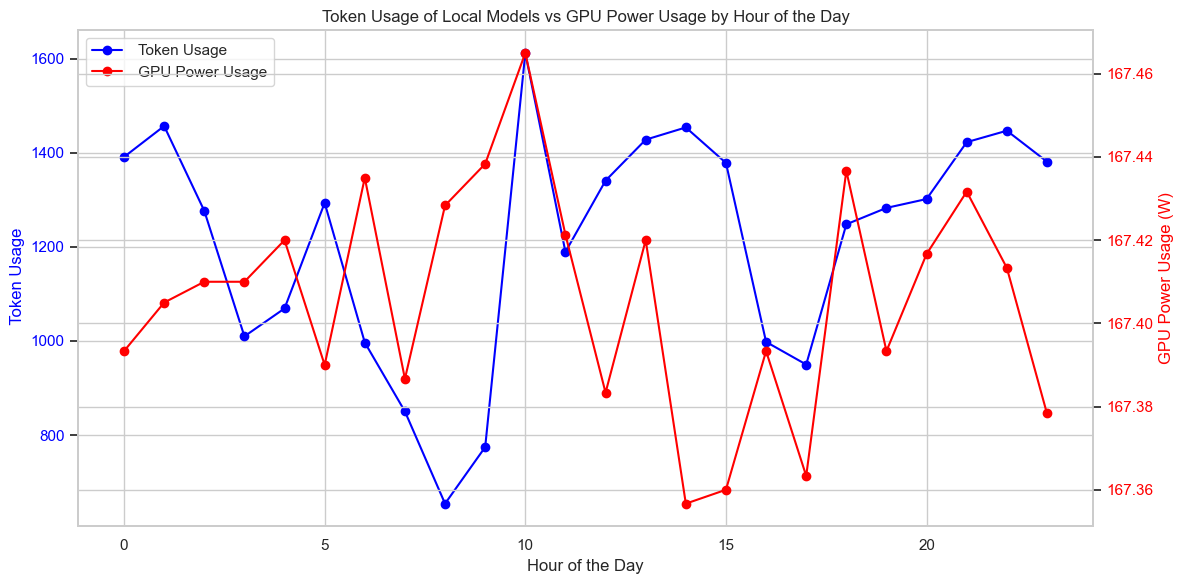

<Figure size 640x480 with 0 Axes>

In [94]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot token usage on primary axis (left)
color = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel(' Token Usage', color=color)
ax1.plot(token_usage_local_hour['hour'], token_usage_local_hour['total_tokens'], 
         marker='o', color=color, label=' Token Usage')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color = 'red'
ax2.plot(gpu_power_usage_hour['hour'], gpu_power_usage_hour['total'], 
         marker='o', color=color, label=' GPU Power Usage')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('GPU Power Usage (W)', color=color)
# Add title
plt.title('Token Usage of Local Models vs GPU Power Usage by Hour of the Day')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_vs_gpu_power_usage_by_hour.png")



## Initial Data By models

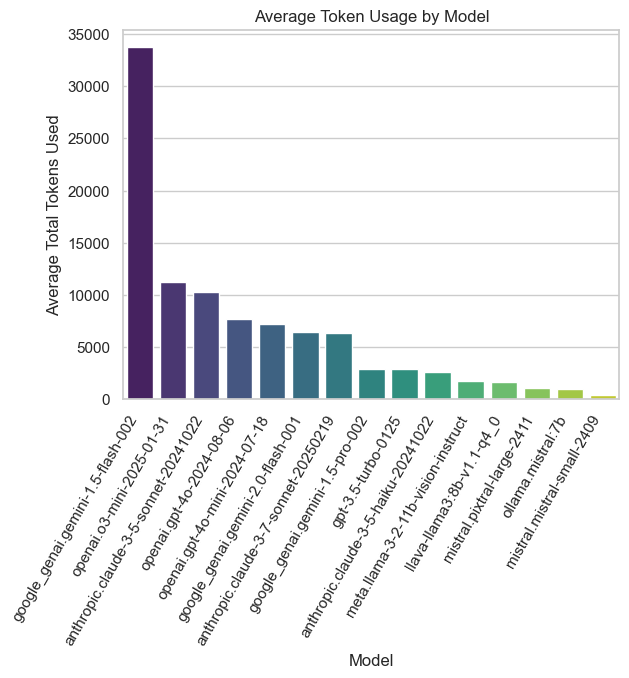

<Figure size 640x480 with 0 Axes>

In [95]:
model_usage = df.groupby(['model']).agg({'total_tokens': 'mean'}).reset_index()
# Plot average token usage by model
model_usage.sort_values(by='total_tokens', ascending=False, inplace=True)

sns.barplot(data=model_usage, x='model', y='total_tokens', hue='model', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Model')
plt.xticks(rotation=60, ha='right')
plt.show()
# Plot average GPU power usage by model

plt.savefig(f"{output_dir}/token_usage_by_model.png")

Correlation between input and output token usage: 0.19


C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\356212852.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_correlation = model_correlation.groupby('model').apply(lambda x: x.iloc[0, 3], include_groups = True).reset_index()
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\356212852.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_correlation, x='model', y='correlation', palette='viridis')


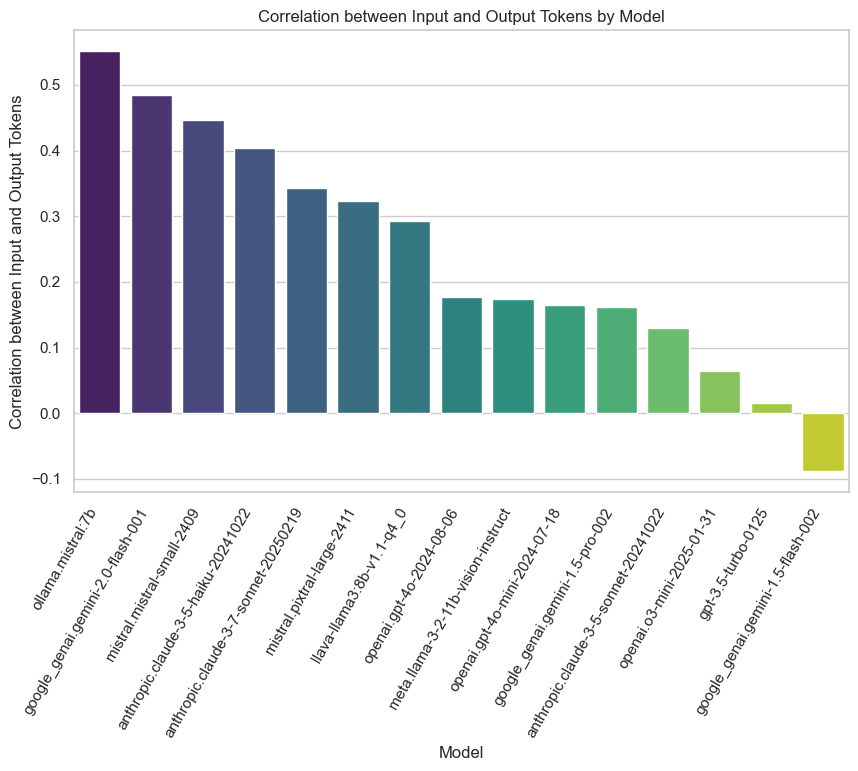

In [96]:
# check correlation between input and output token usage
correlation = df[['prompt_tokens', 'response_tokens']].corr().iloc[0, 1]
print(f"Correlation between input and output token usage: {correlation:.2f}")
# check correlation between input and output token usage by model
model_correlation = df.groupby('model')[['prompt_tokens', 'response_tokens']].corr()
# for each model, have the correlation between input and output token usage
model_correlation = model_correlation.reset_index()
model_correlation = model_correlation[model_correlation['model'] != 'all']
model_correlation = model_correlation.groupby('model').apply(lambda x: x.iloc[0, 3], include_groups = True).reset_index()
model_correlation.columns = ['model', 'correlation']
model_correlation.sort_values(by='correlation', ascending=False, inplace=True)
# plot this
plt.figure(figsize=(10, 6))
sns.barplot(data=model_correlation, x='model', y='correlation', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Correlation between Input and Output Tokens')
plt.title('Correlation between Input and Output Tokens by Model')
plt.xticks(rotation=60, ha='right')


plt.savefig(f"{output_dir}/correlation_input_output_tokens_by_model.png")

# Second Data

In [97]:
gpu_power_usage_2 = pd.read_csv('./data/Second/GPU Power Usage-data-as-joinbyfield-2025-05-08 14_54_19.csv', header=1)
gpu_power_usage_2['total'] = gpu_power_usage_2[[x for x in gpu_power_usage_2.columns if 'GPU' in x]].sum(axis=1)
gpu_power_usage_2['time_bucket'] = pd.to_datetime(gpu_power_usage_2['Time'], format='mixed').dt.floor('h')
gpu_power_usage_2['day'] = gpu_power_usage_2['time_bucket'].dt.date
gpu_power_usage_2['hour'] = gpu_power_usage_2['time_bucket'].dt.hour
# now only have the total power usage
gpu_power_usage_2 = gpu_power_usage_2[['total', 'time_bucket', 'day', 'hour']]
gpu_power_usage_2

,total,time_bucket,day,hour
0,1228.9,2025-04-23 02:00:00,2025-04-23,2
1,1232.3,2025-04-23 03:00:00,2025-04-23,3
2,1227.7,2025-04-23 03:00:00,2025-04-23,3
3,1246.3,2025-04-23 04:00:00,2025-04-23,4
4,1231.9,2025-04-23 04:00:00,2025-04-23,4
...,...,...,...,...
740,1243.4,2025-05-08 12:00:00,2025-05-08,12
741,1241.8,2025-05-08 13:00:00,2025-05-08,13
742,1243.9,2025-05-08 13:00:00,2025-05-08,13
743,1243.9,2025-05-08 14:00:00,2025-05-08,14


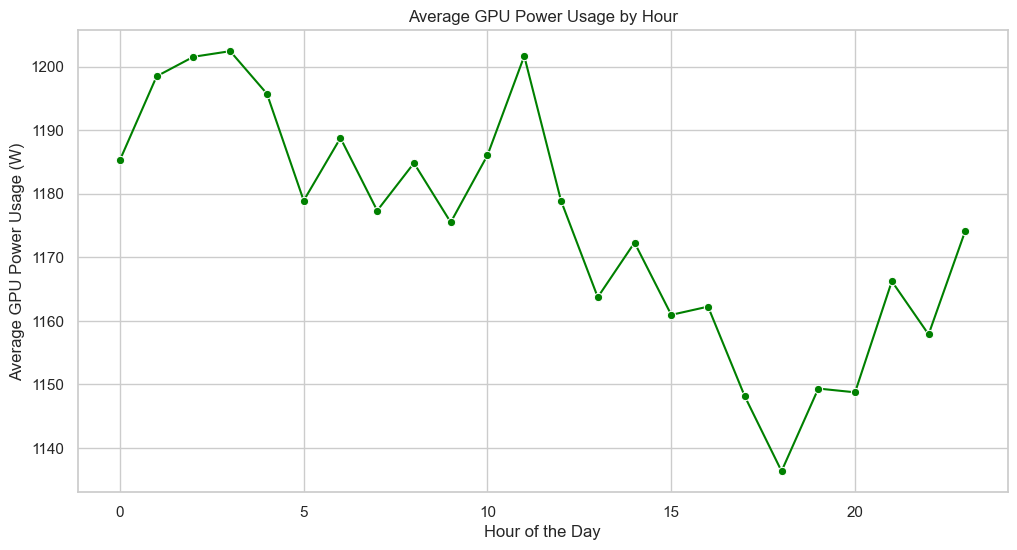

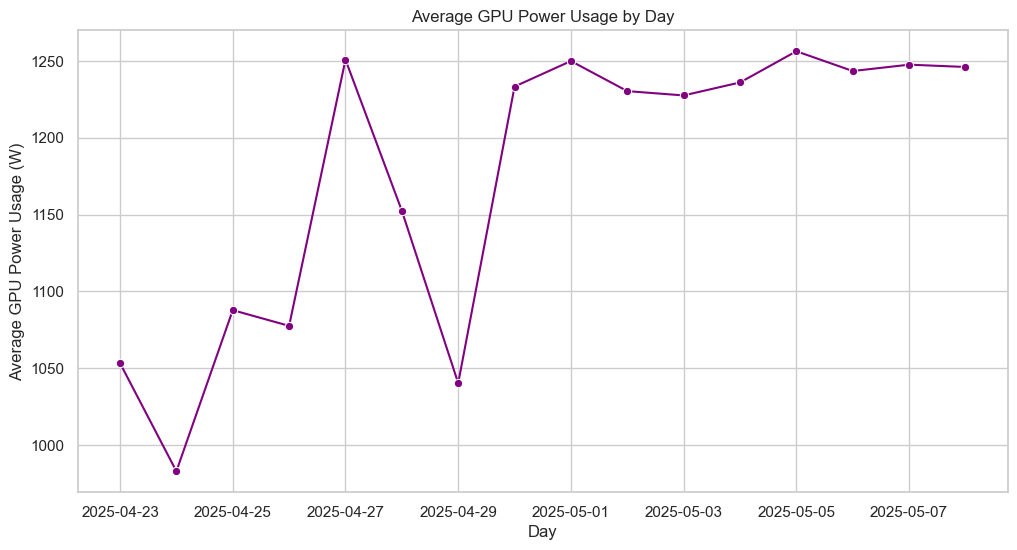

In [98]:
gpu_power_usage_2_hour = gpu_power_usage_2.groupby(['hour']).agg({'total': 'mean'}).reset_index()   
gpu_power_usage_2_day = gpu_power_usage_2.groupby(['day']).agg({'total': 'mean'}).reset_index()

# plot this
plt.figure(figsize=(12, 6))
# Plot average GPU power usage by hour
sns.lineplot(data=gpu_power_usage_2_hour, x='hour', y='total', marker='o', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Average GPU Power Usage (W)')
plt.title('Average GPU Power Usage by Hour')


# Plot average GPU power usage by day
plt.figure(figsize=(12, 6))
sns.lineplot(data=gpu_power_usage_2_day, x='day', y='total', marker='o', color='purple')
plt.xlabel('Day')
plt.ylabel('Average GPU Power Usage (W)')
plt.title('Average GPU Power Usage by Day')
# Show the plots

plt.savefig(f"{output_dir}/gpu_power_usage_by_day_and_hour.png")

In [99]:
tensor_core_utilization_2 = pd.read_csv('./data/Second/Tensor Core Utilization-data-as-joinbyfield-2025-05-08 14_56_20.csv', header=1)
# replace nan with 0 
tensor_core_utilization_2['total'] = tensor_core_utilization_2[[x for x in tensor_core_utilization_2.columns if 'GPU' in x]].sum(axis=1)
tensor_core_utilization_2['total'].describe()

count    372.000000
mean       0.041078
std        0.071148
min        0.000000
25%        0.000000
50%        0.000839
75%        0.025038
max        0.225000
Name: total, dtype: float64

# Third

In [100]:
memory_utilization_3 = pd.read_csv('./data/Third/GPU Framebuffer Mem Used-data-as-joinbyfield-2025-05-27 11_13_40.csv', header=1)

gpu_power_usage_3 = pd.read_csv('./data/Third/GPU Power Usage-data-as-joinbyfield-2025-05-27 11_12_32.csv', header=1)

gpu_utilization_3 = pd.read_csv('./data/Third/GPU Utilization-data-as-joinbyfield-2025-05-27 11_13_02.csv', header=1)

tensor_core_utilization_3 = pd.read_csv('./data/Third/Tensor Core Utilization-data-as-joinbyfield-2025-05-27 11_13_15.csv', header=1)

token_usage_3 = pd.read_csv('./data/Third/Token Usage by Affiliation-data-2025-05-27 11_10_12.csv', header=1)
token_usage_3.columns = ['time', 'metric', 'total_tokens']
# Rename columns to ensure proper aggregation
token_usage_3['Unit'] = token_usage_3['total_tokens'].str.extract(r'([KM][a-zA-Z]*)\b')[0]
token_usage_3['Unit'] = [1000 if 'K' in str(x) else 1e6 if 'M' in str(x) else 1 for x in token_usage_3['Unit'].fillna('')]
token_usage_3['number'] = token_usage_3['total_tokens'].str.replace(r'[^\d.]', '', regex=True).astype(float)
token_usage_3['total_tokens'] = token_usage_3['number'] * token_usage_3['Unit']
# Plot the affiliation data
token_usage_3.drop(columns=['number', 'Unit'], inplace=True)


model_usage_3 = pd.read_csv("./data/Third/Token Usage by Model-data-2025-05-27 11_10_26.csv", header=1)
model_usage_3.columns = ['time', 'model', 'total_tokens']

# lines to convert total_tokens to numeric
set([x[1] if len(x) > 1 else " " for x in model_usage_3.total_tokens.str.split(' ')])
model_usage_3['Unit'] = model_usage_3['total_tokens'].str.extract(r'([KM][a-zA-Z]*)\b')[0]
model_usage_3['Unit'] = [1000 if 'K' in str(x) else 1e6 if 'M' in str(x) else 1 for x in model_usage_3['Unit'].fillna('')]
model_usage_3['number'] = model_usage_3['total_tokens'].str.replace(r'[^\d.]', '', regex=True).astype(float)
model_usage_3['total_tokens'] = model_usage_3['number'] * model_usage_3['Unit']

# based on this if K in string multiply by 1000, else multiply by 1e6
model_usage_3.drop(columns=['number', 'Unit'], inplace=True)

In [101]:
affiliation_usage_3 = token_usage_3.groupby(['metric']).agg({'total_tokens': 'mean'}).reset_index()
affiliation_usage_3.columns = ['primary_affiliation', 'total_tokens']

token_usage_3

,time,metric,total_tokens
0,2025-05-13 00:00:00,Alum,54400.0
1,2025-05-13 00:00:00,Faculty,36300000.0
2,2025-05-13 00:00:00,Member,24100.0
3,2025-05-13 00:00:00,Student,1120000.0
4,2025-05-13 00:00:00,Unknown,26700.0
...,...,...,...
1396,2025-05-26 22:00:00,Unknown,282000.0
1397,2025-05-26 23:00:00,Faculty,655000.0
1398,2025-05-26 23:00:00,Member,50600.0
1399,2025-05-26 23:00:00,Student,2310000.0


In [102]:
local_model_usage_3 = model_usage_3[model_usage_3['model'].str.contains('|'.join(local_models))]
local_model_usage_3['time_bucket'] = pd.to_datetime(local_model_usage_3['time'], format='mixed').dt.floor('h')
local_model_usage_3['day'] = local_model_usage_3['time_bucket'].dt.date
local_model_usage_3['hour'] = local_model_usage_3['time_bucket'].dt.hour
local_model_usage_3_hour = local_model_usage_3.groupby(['hour']).agg({'total_tokens': 'sum'}).reset_index()
local_model_usage_3_day = local_model_usage_3.groupby(['day']).agg({'total_tokens': 'sum'}).reset_index()
local_model_usage_3_hour_day = local_model_usage_3.groupby(['day', 'hour']).agg({'total_tokens': 'sum'}).reset_index()
pass


C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\1171103233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_model_usage_3['time_bucket'] = pd.to_datetime(local_model_usage_3['time'], format='mixed').dt.floor('h')
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\1171103233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_model_usage_3['day'] = local_model_usage_3['time_bucket'].dt.date
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\1171103233.py:4: SettingWithCopyWarning: 
A 

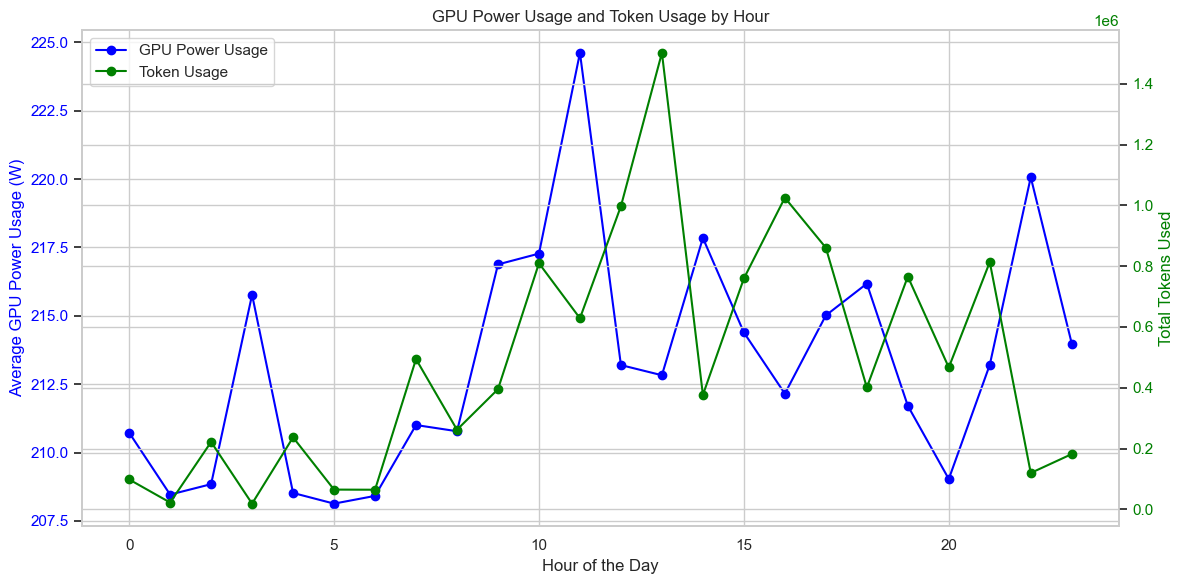

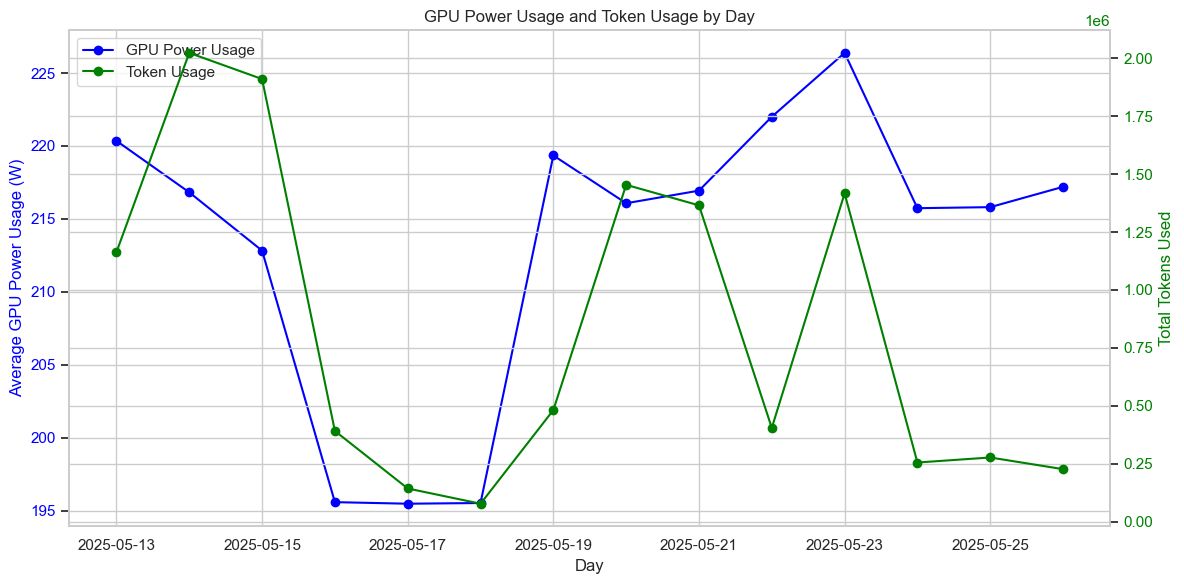

In [121]:
# add up power utilization 
gpu_power_usage_3['total'] = gpu_power_usage_3[[x for x in gpu_power_usage_3.columns if 'GPU' in x]].sum(axis=1)
# bucket times into 1 hours intervals
gpu_power_usage_3['time_bucket'] = pd.to_datetime(gpu_power_usage_3['Time'], format='mixed').dt.floor('h')
gpu_power_usage_3['day'] = gpu_power_usage_3['time_bucket'].dt.date
gpu_power_usage_3['hour'] = gpu_power_usage_3['time_bucket'].dt.hour

# plot 
# Group GPU power usage by hour and day
gpu_power_usage_3_hour = gpu_power_usage_3.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_power_usage_3_day = gpu_power_usage_3.groupby(['day']).agg({'total': 'mean'}).reset_index()

# Plot GPU power usage and token usage by hour
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_power_usage_3_hour['hour'], gpu_power_usage_3_hour['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Total Tokens Used', color=color2)
ax2.plot(local_model_usage_3_hour['hour'], local_model_usage_3_hour['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legends
plt.title('GPU Power Usage and Token Usage by Hour')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
# Plot GPU power usage and token usage by day
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_power_usage_3_day['day'], gpu_power_usage_3_day['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Total Tokens Used', color=color2)
ax2.plot(local_model_usage_3_day['day'], local_model_usage_3_day['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legends
plt.title('GPU Power Usage and Token Usage by Day')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [122]:
gpu_power_usage_hour_day['time'] = gpu_power_usage_hour_day['day'].astype(str) + ' ' + gpu_power_usage_hour_day['hour'].astype(str) 

token_usage_local_hour_day['time'] = token_usage_local_hour_day['day'].astype(str) + ' ' + token_usage_local_hour_day['hour'].astype(str)


# merge these two dataframes on time
merged_3 = pd.merge(gpu_power_usage_hour_day, token_usage_local_hour_day, on='time', how='inner')
merged_3

,day_x,hour_x,total,time,day_y,hour_y,total_tokens
0,2025-04-15,11,167.353846,2025-04-15 11,2025-04-15,11,799.526316
1,2025-04-15,12,167.383333,2025-04-15 12,2025-04-15,12,1195.312500
2,2025-04-15,13,167.420000,2025-04-15 13,2025-04-15,13,2357.755556
3,2025-04-15,14,167.356667,2025-04-15 14,2025-04-15,14,1300.386364
4,2025-04-15,15,167.360000,2025-04-15 15,2025-04-15,15,937.250000
5,2025-04-15,16,167.393333,2025-04-15 16,2025-04-15,16,1760.450000
6,2025-04-15,17,167.363333,2025-04-15 17,2025-04-15,17,1051.298246
7,2025-04-15,18,167.436667,2025-04-15 18,2025-04-15,18,1052.322222
8,2025-04-15,19,167.393333,2025-04-15 19,2025-04-15,19,993.356164
9,2025-04-15,20,167.416667,2025-04-15 20,2025-04-15,20,779.294872


C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\1543736197.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\1543736197.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, 'GPU Power Usage and Token Usage by Hour')

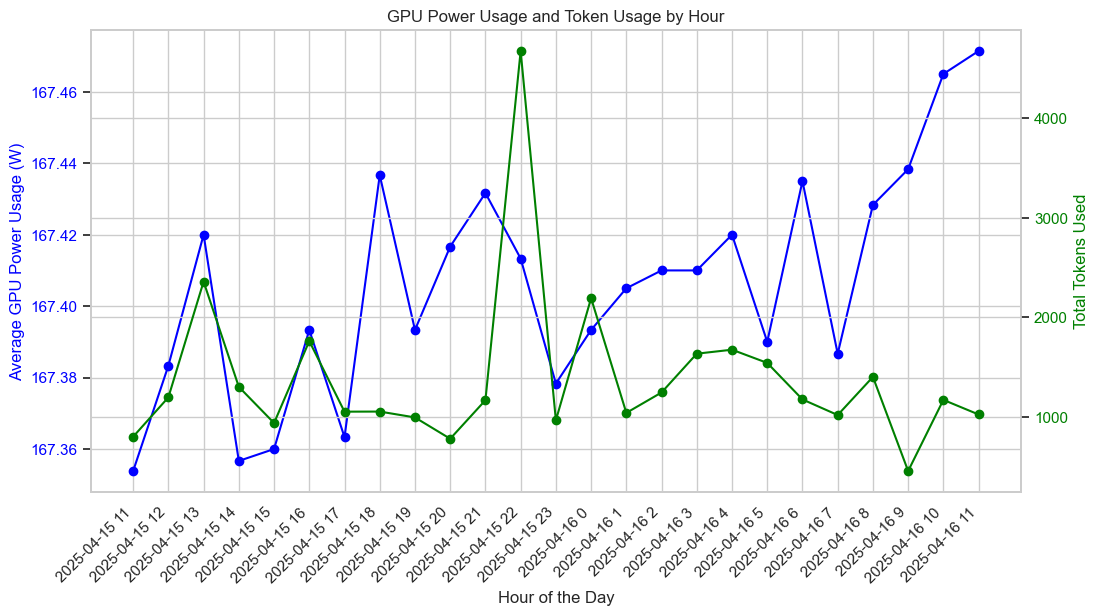

In [123]:

# Plot GPU power usage and token usage by hour
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(merged_3['time'], merged_3['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# same for the token usage
# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Total Tokens Used', color=color2)
ax2.plot(merged_3['time'], merged_3['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

plt.title('GPU Power Usage and Token Usage by Hour')

In [106]:
affiliation_usage_3

,primary_affiliation,total_tokens
0,Alum,6.776730e+04
1,ExEmployee,1.397500e+04
2,Faculty,6.446476e+05
3,Member,4.824854e+04
4,Staff,4.486035e+05
5,Student,1.560133e+06
6,Unknown,3.080360e+05


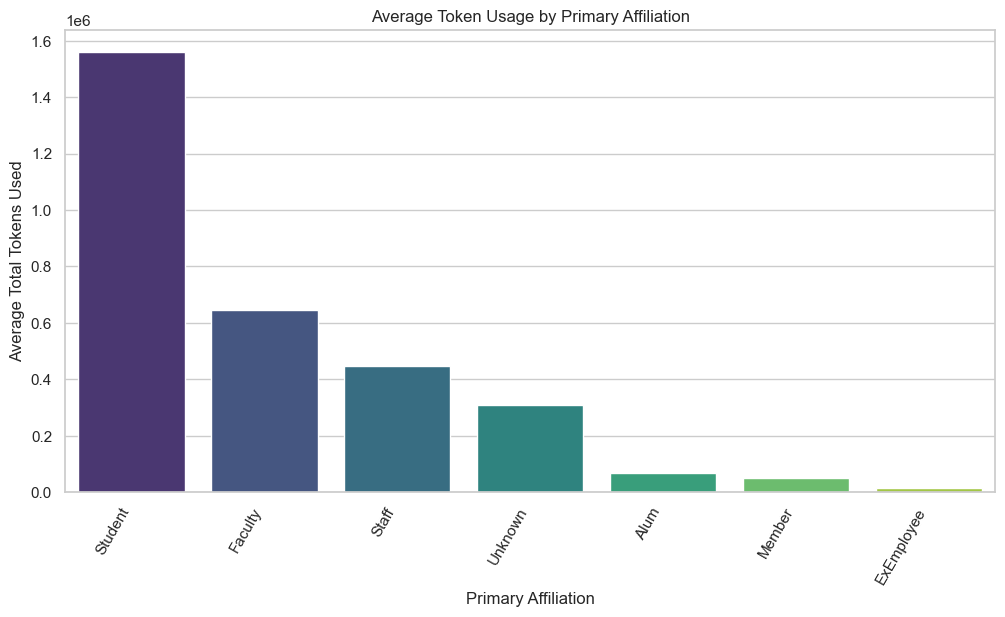

In [107]:
# plot the affiliations
plt.figure(figsize=(12, 6))
affiliation_usage_3 = affiliation_usage_3.sort_values(by='total_tokens', ascending=False)

sns.barplot(data=affiliation_usage_3, x='primary_affiliation', y='total_tokens', hue='primary_affiliation', palette='viridis')
plt.xlabel('Primary Affiliation')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Primary Affiliation')
plt.xticks(rotation=60, ha='right')

plt.savefig(f"{output_dir}/token_usage_by_affiliation_3rd_dataset.png")

In [108]:
# aggregate by model
model_usage_3 = pd.read_csv("./data/Third/Token Usage by Model-data-2025-05-27 11_10_26.csv", header=1)
model_usage_3.columns = ['time', 'model', 'total_tokens']

# lines to convert total_tokens to numeric
set([x[1] if len(x) > 1 else " " for x in model_usage_3.total_tokens.str.split(' ')])
model_usage_3['Unit'] = model_usage_3['total_tokens'].str.extract(r'([KM][a-zA-Z]*)\b')[0]
model_usage_3['Unit'] = [1000 if 'K' in str(x) else 1e6 if 'M' in str(x) else 1 for x in model_usage_3['Unit'].fillna('')]
model_usage_3['number'] = model_usage_3['total_tokens'].str.replace(r'[^\d.]', '', regex=True).astype(float)
model_usage_3['total_tokens'] = model_usage_3['number'] * model_usage_3['Unit']

# based on this if K in string multiply by 1000, else multiply by 1e6
model_usage_3.drop(columns=['number', 'Unit'], inplace=True)

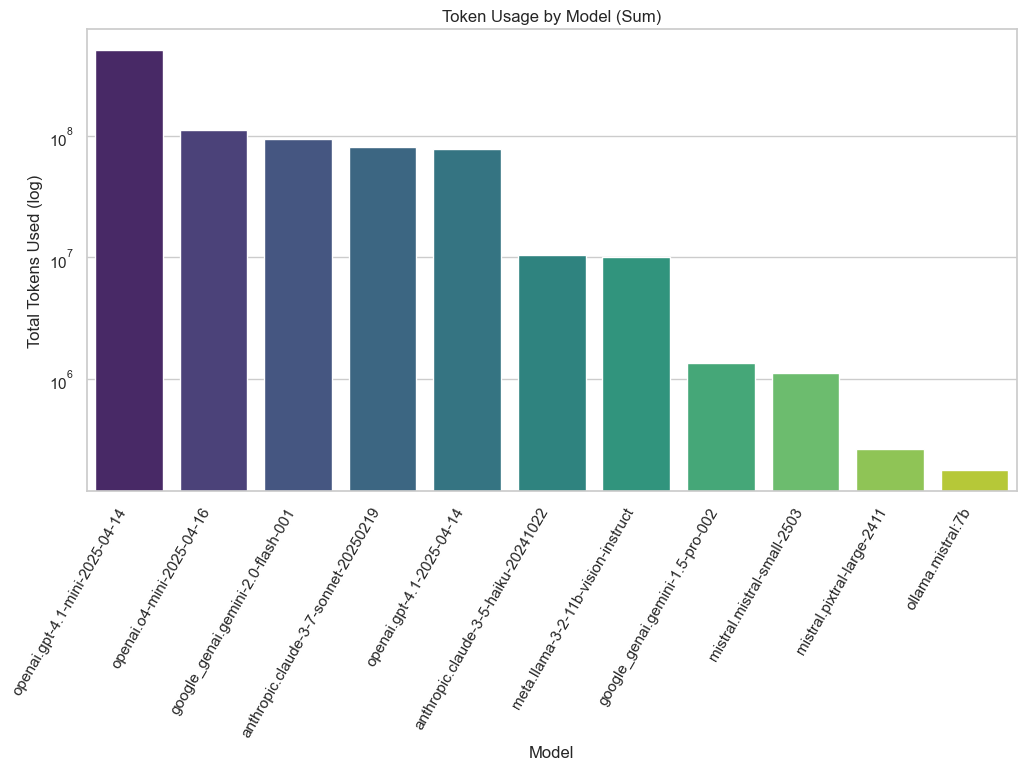

In [109]:
grouped_model_usage_3 = model_usage_3.groupby(['model']).agg({'total_tokens': 'sum'}).reset_index()
grouped_model_usage_3.sort_values(by='total_tokens', ascending=False, inplace=True)
# plot 
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_model_usage_3, x='model', y='total_tokens', hue='model', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Total Tokens Used (log)')
plt.title('Token Usage by Model (Sum)')
plt.xticks(rotation=60, ha='right')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.savefig(f"{output_dir}/token_usage_by_model_3rd_dataset.png")


# Merging the datasets

In [110]:
# Things I want to check! 
model_usage_1 = token_usage[['log_date', 'model', 'prompt_tokens', 'response_tokens']]
model_usage_1['total_tokens'] = model_usage_1['prompt_tokens'] + model_usage_1['response_tokens']
model_usage_1.drop(columns=['prompt_tokens', 'response_tokens'], inplace=True)

model_usage_1.columns = ['time', 'model', 'total_tokens']
print(model_usage_1.columns )

model_usage_1['time'] = pd.to_datetime(model_usage_1['time'], format = 'mixed').dt.tz_convert('UTC')
model_usage_1['time'] = pd.to_datetime(model_usage_1['time'], format = 'mixed').dt.floor('h')
model_usage_1['time'] = model_usage_1['time'].dt.tz_localize(None)
# merge the two 
total_data = pd.concat([model_usage_1, model_usage_3], ignore_index=True)
total_data['time'] = pd.to_datetime(total_data['time'], format = 'mixed').dt.floor('h')
total_data.head(5)


Index(['time', 'model', 'total_tokens'], dtype='object')


,time,model,total_tokens
0,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,11284.0
1,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,11716.0
2,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,12067.0
3,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,12582.0
4,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,13460.0


In [111]:

# Now process the data,,,,  
total_data['hour'] = total_data['time'].dt.hour
total_data['day'] = total_data['time'].dt.date  # Extract date portion

# only local models
local_models = ['llama', 'mistral']
total_data = total_data[total_data['model'].str.contains('|'.join(local_models), case=False, na=False)]

# group into hour and day
total_token_data = total_data.groupby(['day', 'hour']).agg({'total_tokens': 'mean'}).reset_index()
total_token_data['time'] = total_token_data['day'].astype(str) + ' ' + total_token_data['hour'].astype(str)
total_token_data_day = total_data.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()
total_token_data_day_hour = total_data.groupby(['day', 'hour']).agg({'total_tokens': 'mean'}).reset_index()
total_token_data_day_hour['time'] = total_token_data_day_hour['day'].astype(str) + ' ' + total_token_data_day_hour['hour'].astype(str)

In [112]:

# doing the same for the power usage
gpu_pu_1 = gpu_power_usage[['time_bucket', 'total']]
gpu_pu_2 = gpu_power_usage_2[['time_bucket', 'total']]
gpu_pu_3 = gpu_power_usage_3[['time_bucket', 'total']]

total_power_data = pd.concat([gpu_pu_1, gpu_pu_2, gpu_pu_3], ignore_index=True)
total_power_data['hour'] = total_power_data['time_bucket'].dt.hour
total_power_data['day'] = total_power_data['time_bucket'].dt.date  # Extract date portion
total_power_data_day = total_power_data.groupby(['day']).agg({'total': 'mean'}).reset_index()

total_power_data_day_hour = total_power_data.groupby(['day', 'hour']).agg({'total': 'mean'}).reset_index()
total_power_data_day_hour['time'] =total_power_data_day_hour['day'].astype(str) + ' ' + total_power_data_day_hour['hour'].astype(str)
total_power_data_day_hour

,day,hour,total,time
0,2025-04-15,11,167.353846,2025-04-15 11
1,2025-04-15,12,167.383333,2025-04-15 12
2,2025-04-15,13,167.420000,2025-04-15 13
3,2025-04-15,14,167.356667,2025-04-15 14
4,2025-04-15,15,167.360000,2025-04-15 15
...,...,...,...,...
729,2025-05-26,19,212.766667,2025-05-26 19
730,2025-05-26,20,217.400000,2025-05-26 20
731,2025-05-26,21,217.033333,2025-05-26 21
732,2025-05-26,22,222.500000,2025-05-26 22


In [113]:
total_token_data_day

,day,total_tokens
0,2024-08-08,610.250000
1,2024-08-09,563.100000
2,2024-08-10,2745.928571
3,2024-08-12,333.066667
4,2024-08-13,1324.440000
...,...,...
250,2025-05-22,4211.562500
251,2025-05-23,14757.281250
252,2025-05-24,2655.416667
253,2025-05-25,2881.229167


In [119]:
total_merged_data = pd.merge(total_token_data_day_hour, total_power_data_day_hour, on='time', how='inner')
total_merged_data

,day_x,hour_x,total_tokens,time,day_y,hour_y,total
0,2025-04-15,11,799.526316,2025-04-15 11,2025-04-15,11,167.353846
1,2025-04-15,12,1195.312500,2025-04-15 12,2025-04-15,12,167.383333
2,2025-04-15,13,2357.755556,2025-04-15 13,2025-04-15,13,167.420000
3,2025-04-15,14,1300.386364,2025-04-15 14,2025-04-15,14,167.356667
4,2025-04-15,15,937.250000,2025-04-15 15,2025-04-15,15,167.360000
...,...,...,...,...,...,...,...
279,2025-05-26,19,1190.750000,2025-05-26 19,2025-05-26,19,212.766667
280,2025-05-26,20,1109.750000,2025-05-26 20,2025-05-26,20,217.400000
281,2025-05-26,21,255.500000,2025-05-26 21,2025-05-26,21,217.033333
282,2025-05-26,22,10290.500000,2025-05-26 22,2025-05-26,22,222.500000


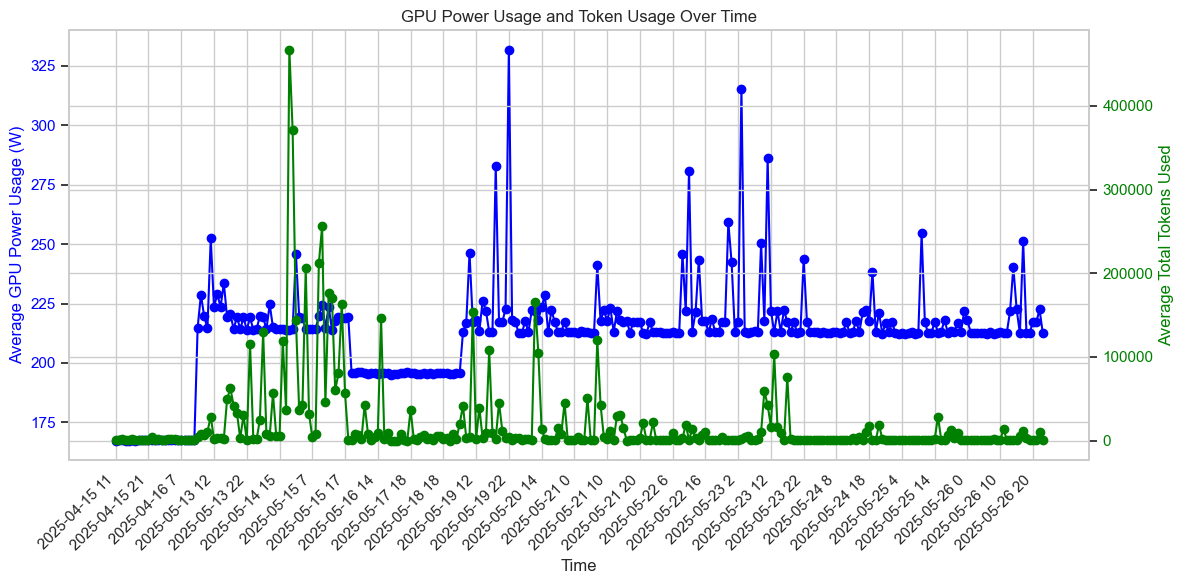

In [120]:
# plot the merged data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(total_merged_data['time'], total_merged_data['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Set tick spacing for the x-axis
ax1.set_xticks(total_merged_data['time'][::10])  # Adjust the step size as needed
ax1.set_xticklabels(total_merged_data['time'][::10], rotation=45, ha='right')

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.plot(total_merged_data['time'], total_merged_data['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('GPU Power Usage and Token Usage Over Time')
plt.tight_layout()
plt.show()



C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\4066032846.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\4066032846.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
C:\Users\Biratal\AppData\Local\Temp\ipykernel_150888\4066032846.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, 'GPU Power Usage and Token Usage by Day')

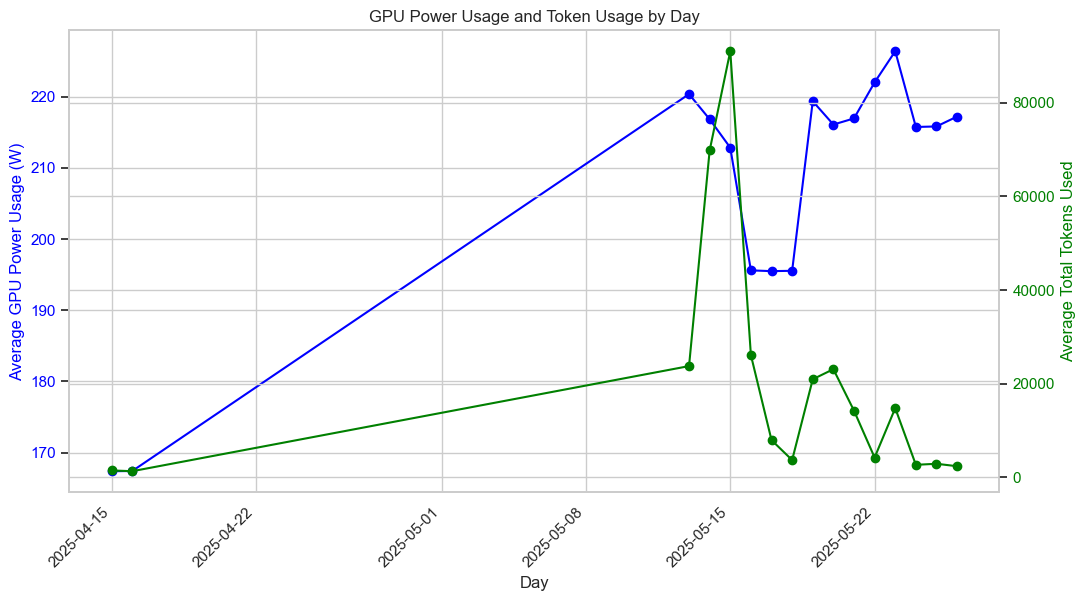

In [ ]:
total_power_data_day = total_power_data.groupby(total_power_data['day']).agg({'total': 'mean'}).reset_index()
total_token_data_day
# merge these two dataframes on day
merged_day = pd.merge(total_power_data_day, total_token_data_day, on='day', how='inner')

# plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(merged_day['day'], merged_day['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.plot(merged_day['day'], merged_day['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.title('GPU Power Usage and Token Usage by Day')


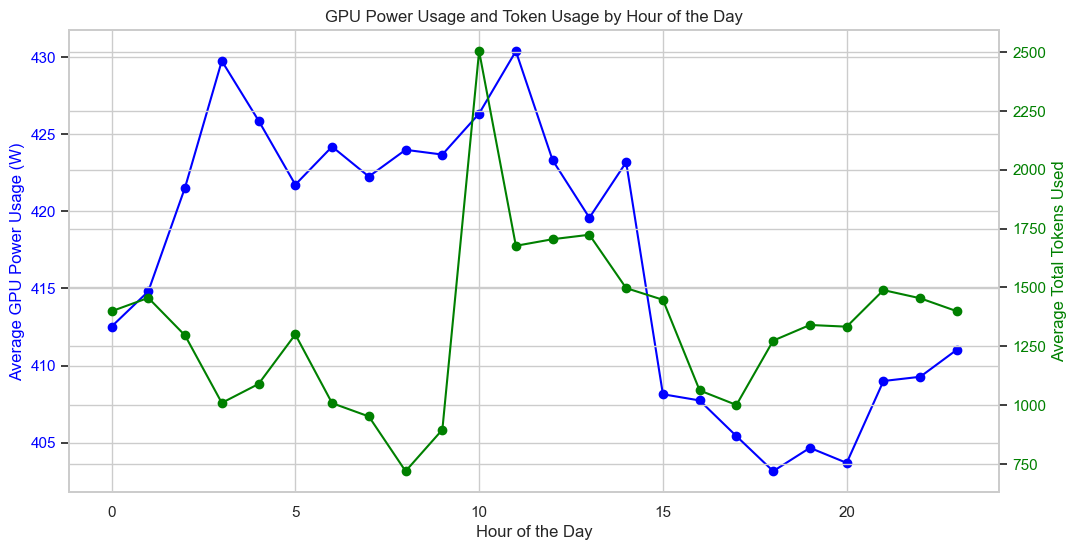

In [ ]:
# look at it by hour instead of by day
gpu_pu['hour'] = gpu_pu['time_bucket'].dt.hour
gpu_pu['day'] = gpu_pu['time_bucket'].dt.date

# now aggregate
gpu_pu_hour = gpu_pu.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_pu_day = gpu_pu.groupby(['day']).agg({'total': 'mean'}).reset_index()

# now plot
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot GPU power usage on primary axis (bottom)
color1 = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_pu_hour['hour'], gpu_pu_hour['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (top) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.set_xlim(ax1.get_xlim())  # Ensure both x-axes are aligned
ax2.plot(total_data_hour['hour'], total_data_hour['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)
# Add title
plt.title('GPU Power Usage and Token Usage by Hour of the Day')

plt.savefig(f"{output_dir}/gpu_power_usage_and_token_usage_by_hour_combined_datasets.png")
